In [1]:
import pandas as pd
import datetime as dt
import numpy as np

from csv import writer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('xrp.csv')
print(df)

      Unnamed: 0 formatted_date      high       low      open     close  \
0              0     2019-01-01  0.364771  0.350402  0.365675  0.364771   
1              1     2019-01-02  0.378021  0.359574  0.374505  0.375243   
2              2     2019-01-03  0.374505  0.357675  0.359753  0.360224   
3              3     2019-01-04  0.364642  0.352785  0.356347  0.356747   
4              4     2019-01-05  0.361069  0.353987  0.354750  0.355275   
...          ...            ...       ...       ...       ...       ...   
1515        1515     2023-02-24  0.390547  0.374133  0.378507  0.378477   
1516        1516     2023-02-25  0.379419  0.372250  0.378085  0.378085   
1517        1517     2023-02-26  0.380606  0.375420  0.378005  0.378041   
1518        1518     2023-02-27  0.380042  0.372158  0.379121  0.379115   
1519        1519     2023-02-28  0.382433  0.373027  0.377133  0.377150   

          volume  adjclose  
0      449347622  0.364771  
1      543216669  0.375243  
2      43887

In [3]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['close'].rolling(window=ma_3).std()
df.dropna(inplace=True)
df

,Unnamed: 0,formatted_date,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,20,2019-01-21,0.322593,0.317439,0.321078,0.320790,363940431,0.320790,0.005154,0.326211,0.333262,0.343365,0.004171,0.019658
21,21,2019-01-22,0.321078,0.313455,0.319566,0.319491,434125854,0.319491,0.007623,0.325113,0.329989,0.341209,0.004834,0.019676
22,22,2019-01-23,0.320303,0.314923,0.316416,0.316492,375671478,0.316492,0.005380,0.323226,0.326103,0.338411,0.005300,0.018750
23,23,2019-01-24,0.318896,0.314433,0.317859,0.317598,344960253,0.317598,0.004463,0.321547,0.325028,0.336382,0.004881,0.018577
24,24,2019-01-25,0.319069,0.313824,0.317260,0.317165,360076505,0.317165,0.005245,0.320531,0.323904,0.334497,0.004957,0.018415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,1515,2023-02-24,0.390547,0.374133,0.378507,0.378477,953355531,0.378477,0.016414,0.390653,0.387840,0.390471,0.006746,0.010021
1516,1516,2023-02-25,0.379419,0.372250,0.378085,0.378085,552223148,0.378085,0.007169,0.388289,0.387416,0.388889,0.007917,0.009152
1517,1517,2023-02-26,0.380606,0.375420,0.378005,0.378041,441815645,0.378041,0.005186,0.387107,0.387614,0.387894,0.008827,0.009141
1518,1518,2023-02-27,0.380042,0.372158,0.379121,0.379115,1049508853,0.379115,0.007884,0.384334,0.388145,0.387241,0.007606,0.009260


In [4]:
pre_day = 7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high','low','open','H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

# test_size = (int)(len(scaled_data_y) * 0.3)
# print(test_size)

# x_train = np.array(x_total[:len(x_total)])
# # x_test = np.array(x_total[len(x_total)-test_size:])
# y_train = np.array(y_total[:len(y_total)])
# # y_test = np.array(y_total[len(y_total)-test_size:])

test_size = (int)(len(scaled_data_y) * 0.3)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

450
(1043, 7, 9) (1043, 1) (450, 7, 9) (450, 1)


In [5]:
# Build model
model = Sequential()

model.add(GRU(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
# model.save("../../model/BOOSTING/GRU_boosting_close.h5")

Epoch 1/120
40/40 [==============================] - 37s 41ms/step - loss: 0.0120
Epoch 2/120
40/40 [==============================] - 1s 24ms/step - loss: 0.0045
Epoch 3/120
40/40 [==============================] - 1s 31ms/step - loss: 0.0043
Epoch 4/120
40/40 [==============================] - 1s 30ms/step - loss: 0.0043
Epoch 5/120
40/40 [==============================] - 1s 30ms/step - loss: 0.0036
Epoch 6/120
40/40 [==============================] - 1s 33ms/step - loss: 0.0040
Epoch 7/120
40/40 [==============================] - 1s 28ms/step - loss: 0.0034
Epoch 8/120
40/40 [==============================] - 1s 27ms/step - loss: 0.0036
Epoch 9/120
40/40 [==============================] - 1s 25ms/step - loss: 0.0035
Epoch 10/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0032
Epoch 11/120
40/40 [==============================] - 1s 19ms/step - loss: 0.0029
Epoch 12/120
40/40 [==============================] - 1s 21ms/step - loss: 0.0032
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_train)
predict_price = scala_y.inverse_transform(predict_price)
y_train_price = scala_y.inverse_transform(y_train)

error = pd.concat([pd.DataFrame(predict_price,columns=['predict_price'],index=None), pd.DataFrame(y_train_price,columns=['y_train_price'],index=None)], axis=1)
error['error_price'] = error['predict_price'] - error['y_train_price']
print(error)

33/33 [==============================] - 10s 8ms/step
      predict_price  y_train_price  error_price
0          0.324440       0.294863     0.029577
1          0.312234       0.289558     0.022676
2          0.306121       0.320461    -0.014340
3          0.333447       0.310036     0.023411
4          0.325504       0.308517     0.016987
...             ...            ...          ...
1038       1.030851       0.990930     0.039921
1039       1.021493       0.972312     0.049181
1040       1.006308       0.922244     0.084064
1041       0.972374       0.847029     0.125345
1042       0.847839       0.805595     0.042244

[1043 rows x 3 columns]


In [7]:

from sklearn.linear_model import ElasticNet
import pickle
elasticnet =  ElasticNet(alpha= 0.01, l1_ratio= 0.8, positive= True, random_state= 100, selection= 'random', tol= 0.2, warm_start= True)

In [8]:
elasticnet.fit(error['predict_price'].values.reshape(-1, 1), error['error_price'].values)
# pickle.dump(elasticnet, open("../../model/BOOSTING/booting_elasticnet_close.h5", "wb"))

ElasticNet(alpha=0.01, l1_ratio=0.8, positive=True, random_state=100,
           selection='random', tol=0.2, warm_start=True)

In [9]:
predict_price = model.predict(x_test)
print(predict_price)

15/15 [==============================] - 0s 6ms/step
[[0.41323787]
 [0.42065555]
 [0.41637266]
 [0.43913865]
 [0.4357733 ]
 [0.4069718 ]
 [0.42435753]
 [0.4243229 ]
 [0.39862603]
 [0.40762174]
 [0.41265565]
 [0.40517896]
 [0.4031934 ]
 [0.41327006]
 [0.42134464]
 [0.45218742]
 [0.48757464]
 [0.5056516 ]
 [0.5401462 ]
 [0.50160116]
 [0.50228107]
 [0.49897176]
 [0.5021153 ]
 [0.46817327]
 [0.446688  ]
 [0.4453925 ]
 [0.43774152]
 [0.44464815]
 [0.44697577]
 [0.4286967 ]
 [0.42809778]
 [0.40018976]
 [0.39433062]
 [0.38627303]
 [0.3762297 ]
 [0.37529135]
 [0.36170954]
 [0.37517148]
 [0.3957289 ]
 [0.38273847]
 [0.38775218]
 [0.39162588]
 [0.3918362 ]
 [0.3831736 ]
 [0.3788759 ]
 [0.36915088]
 [0.36616105]
 [0.3251297 ]
 [0.2945431 ]
 [0.30719262]
 [0.2886969 ]
 [0.29300898]
 [0.2998733 ]
 [0.2775455 ]
 [0.28679484]
 [0.2890569 ]
 [0.28122067]
 [0.28358346]
 [0.28999475]
 [0.27815822]
 [0.27787012]
 [0.30929565]
 [0.31928042]
 [0.33185887]
 [0.42883593]
 [0.46709347]
 [0.48327613]
 [0.47378

In [10]:



predict_error = elasticnet.predict(predict_price)
index=0
predict_price = scala_y.inverse_transform(predict_price)
for error in predict_error:
    predict_price[index]+=error
    index+=1
print(predict_price)



[[0.86301404]
 [0.8756211 ]
 [0.8683419 ]
 [0.907035  ]
 [0.9013153 ]
 [0.85236424]
 [0.881913  ]
 [0.8818541 ]
 [0.83817977]
 [0.8534689 ]
 [0.86202455]
 [0.84931713]
 [0.8459425 ]
 [0.86306876]
 [0.8767923 ]
 [0.9292127 ]
 [0.9893569 ]
 [1.0200804 ]
 [1.0787076 ]
 [1.0131963 ]
 [1.014352  ]
 [1.0087274 ]
 [1.0140703 ]
 [0.9563823 ]
 [0.9198659 ]
 [0.91766405]
 [0.90466046]
 [0.91639894]
 [0.92035496]
 [0.8892878 ]
 [0.88826996]
 [0.8408375 ]
 [0.8308793 ]
 [0.81718457]
 [0.8001149 ]
 [0.7985201 ]
 [0.77543646]
 [0.7983164 ]
 [0.83325577]
 [0.81117725]
 [0.8196986 ]
 [0.8262823 ]
 [0.8266398 ]
 [0.8119168 ]
 [0.80461246]
 [0.7880838 ]
 [0.78300226]
 [0.7132653 ]
 [0.6612803 ]
 [0.68277943]
 [0.65134406]
 [0.6586729 ]
 [0.6703395 ]
 [0.6323912 ]
 [0.64811134]
 [0.65195596]
 [0.6386375 ]
 [0.6426533 ]
 [0.6535499 ]
 [0.63343257]
 [0.6329429 ]
 [0.68635374]
 [0.7033239 ]
 [0.72470224]
 [0.88952446]
 [0.95454705]
 [0.98205113]
 [0.96591395]
 [0.9001315 ]
 [0.9390581 ]
 [0.90318626]
 [0.89

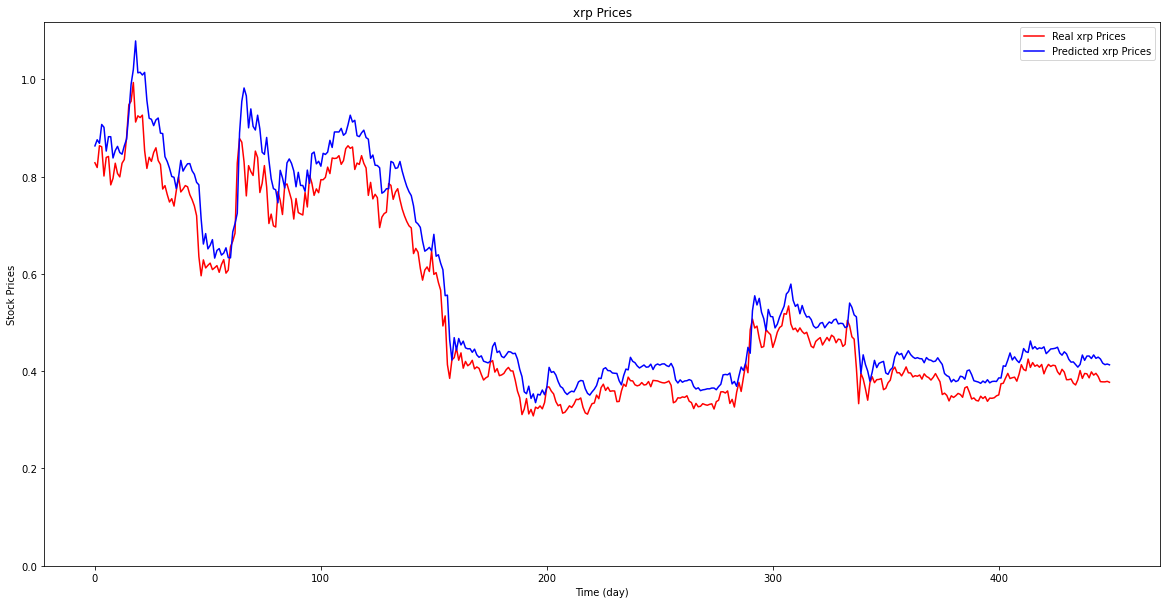

In [11]:
y_test = scala_y.inverse_transform(y_test)
plt.figure(figsize=(20,10))
plt.plot(y_test, color="red", label=f"Real xrp Prices")
plt.plot(predict_price[0:], color="blue", label=f"Predicted xrp Prices")
plt.title(f"xrp Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

TEST

In [12]:
mae = mean_absolute_error(y_test, predict_price)
mape = mean_absolute_percentage_error(y_test, predict_price)
mse = mean_squared_error(y_test, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.05
MAPE: 9.16%
MSE: 0.00
RMSE: 0.05
R2: 0.92


In [13]:
# predict_price_test = model.predict(x_test)
# predict_price_test = scala_y.inverse_transform(predict_price_test)
# y_test = scala_y.inverse_transform(y_test)



In [14]:
# validate = []
# for predict in predict_price_test:
#     predict= elasticnet.predict(np.array([predict]).reshape(-1,1))[0]
#     validate.append(predict)
# df_predict = pd.concat([pd.DataFrame(predict_price_test,columns=['predict_price_test'],index=None), pd.DataFrame(y_test,columns=['y_test'],index=None)], axis=1)
# df_predict['final_predict'] = df_predict['predict_price_test'] + validate
# print(df_predict.to_csv('result.csv'))